<a href="https://colab.research.google.com/github/badrus123/PCD-Enhacement/blob/master/PCD_Enhacment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Image Enhancement using  Dynamic Histogram Equalization**

## Import Library

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as pltImg
import numpy as np
import cv2
from PIL import Image
from datetime import datetime

import matplotlib.colors
import scipy, scipy.misc, scipy.signal

## Image

In [0]:
def showImage(img):
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  axs[0].imshow(img, cmap = 'gray', interpolation = 'bicubic')  
  axs[1].hist(img.flatten(), 256, [0, 256])
  plt.subplots_adjust(right=0.9, top=0.9)
  fig.tight_layout()
  plt.show()

## **Histogram Equalization**

In [0]:
def equalization(img):
  # Getting histogram of the values from the image
  hist, bin_edges = np.histogram(img, 256)

  # Image pixels divided by the size of the image
  pdf = hist/img.size

  # Getting the cummulative frequency of the unique pixel values
  sum_cum = np.cumsum(pdf)

  # Multiplying the cummulative frequency by the maximum value of the pixels
  mul_cum = sum_cum * np.max(img)

  # Getting rounded value of the multiplied results
  round_val = np.round(mul_cum).astype(np.uint8)

  # Mapping the pixels for the equalization
  res = np.copy(img)
  for n in range(255): res[img == n] = round_val[n]

  return res

## **Dynamic Histogram Equalization**


In [0]:
def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei+4, wid+4, ch))
    for i in range(ch):
        Img[:,:,i] = np.pad(img[:,:,i], (2,2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:,:,0] = hsv[:,:,0] * 255
    hsv[:,:,1] = hsv[:,:,1] * 255
    hsv[hsv>255] = 255
    hsv[hsv<0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    fv = fh.conj().T
    
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    I = hsv[:,:,2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh==0] = 0.00001
    dIv[dIv==0] = 0.00001
    dI = np.sqrt(dIh**2+dIv**2).astype(np.uint32)
    di = dI[2:hei+2,2:wid+2]
    
    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh==0] = 0.00001
    dSv[dSv==0] = 0.00001
    dS = np.sqrt(dSh**2+dSv**2).astype(np.uint32)
    ds = dS[2:hei+2,2:wid+2]

    
    h = H[2:hei+2,2:wid+2]
    s = S[2:hei+2,2:wid+2]
    i = I[2:hei+2,2:wid+2].astype(np.uint8)
    
    Imean = scipy.signal.convolve2d(I,np.ones((5,5))/25, mode='same')
    Smean = scipy.signal.convolve2d(S,np.ones((5,5))/25, mode='same')
    
    Rho = np.zeros((hei+4,wid+4))
    for p in range(2,hei+2):
        for q in range(2,wid+2):
            tmpi = I[p-2:p+3,q-2:q+3]
            tmps = S[p-2:p+3,q-2:q+3]
            corre = np.corrcoef(tmpi.flatten('F'),tmps.flatten('F'))
            Rho[p,q] = corre[0,1]
    
    rho = np.abs(Rho[2:hei+2,2:wid+2])
    rho[np.isnan(rho)] = 0
    rd = (rho*ds).astype(np.uint32)
    Hist_I = np.zeros((256,1))
    Hist_S = np.zeros((256,1))
    
    for n in range(0,255):
        temp = np.zeros(di.shape)
        temp[i==n] = di[i==n]
        Hist_I[n+1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i==n] = rd[i==n]
        Hist_S[n+1] = np.sum(temp.flatten('F'))

    return Hist_I, Hist_S

In [0]:
def dynamic_equalization(img, alpha=0.5):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha*hist_s + (1-alpha)*hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)
    
    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    i = hsv[:,:,2].astype(np.uint8)
    
    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0,255):
        i_s[i==n] = s_r[n+1]/255.0
    i_s[i==255] = 1
    hsi_o = np.stack((h,s,i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)
    
    result = result * 255
    result[result>255] = 255
    result[result<0] = 0
    return cv2.cvtColor(result.astype(np.uint8), cv2.COLOR_BGR2GRAY)

## **Peak Signal to Noise Ratio**

In [0]:
def calculatePSNR(img, res):
  img = np.array(img).astype('float32')
  res = np.array(res).astype('float32')
  mse = np.square(np.subtract(img, res)).mean() 
  if mse == 0: return 100
  else: return 20 * np.log10(255./np.sqrt(mse))

### **Comparison**

dataset: [source](https://drive.google.com/open?id=1IQ1ABOuIpEujFPZRnvkRLEtNHRGFqv4K)

1. Image: dataset1.jpg
rm: cannot remove 'dataset1.jpg': No such file or directory


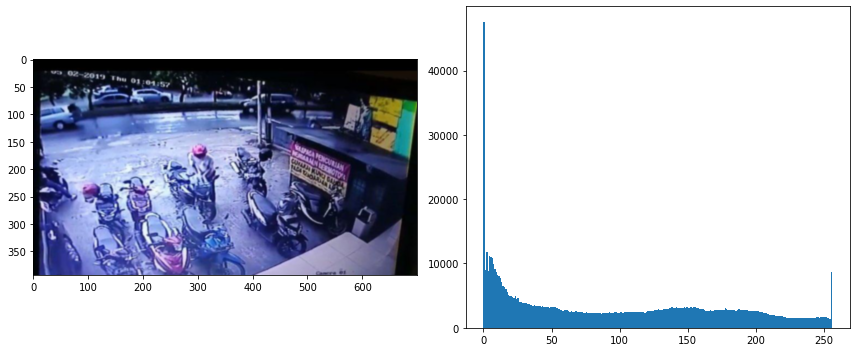

(393, 700, 3)
(196, 350, 3)


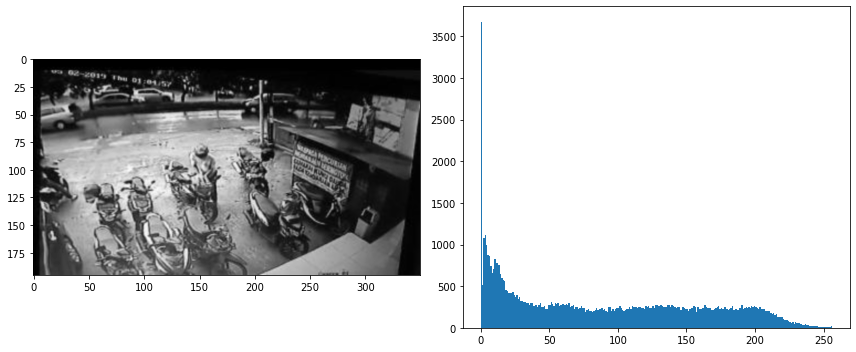

Histogram Equalization
> time-to-compute     : 0:00:01.062015
> peak-to-signal ratio: 15.735150539367257


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dynamic Histogram Equalization
> time-to-compute     : 0:00:09.961210
> peak-to-signal ratio: 21.04403812851155


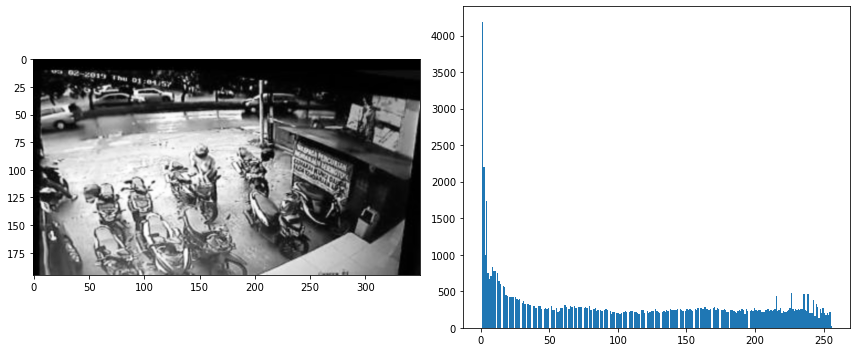

----------------------------------------------------

2. Image: dataset2.jpg
rm: cannot remove 'dataset2.jpg': No such file or directory


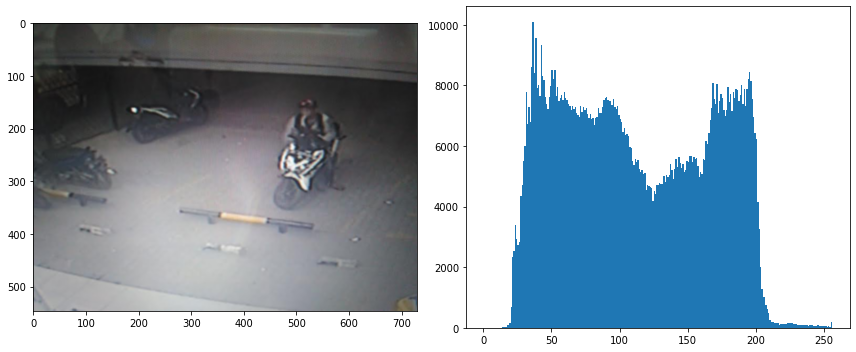

(547, 729, 3)
(273, 364, 3)


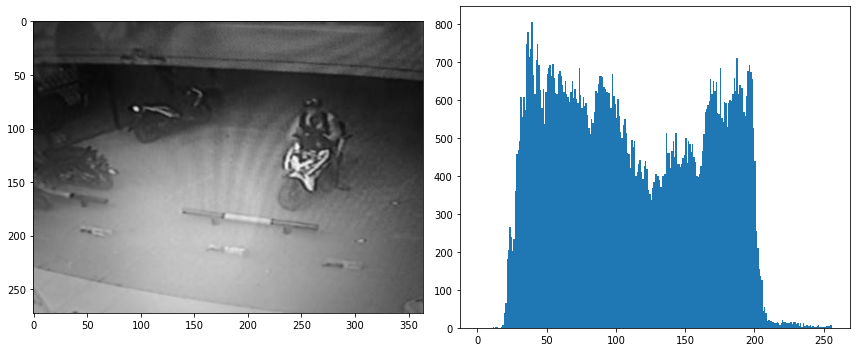

Histogram Equalization
> time-to-compute     : 0:00:01.080370
> peak-to-signal ratio: 18.34335938039222
Dynamic Histogram Equalization
> time-to-compute     : 0:00:14.340153
> peak-to-signal ratio: 17.40515761136681


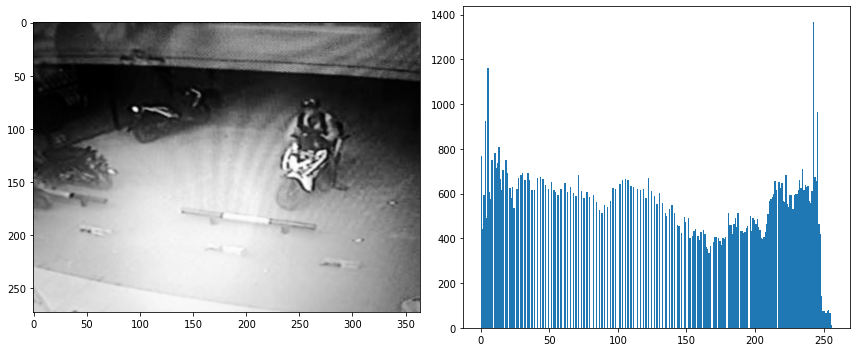

----------------------------------------------------

3. Image: dataset3.jpg
rm: cannot remove 'dataset3.jpg': No such file or directory


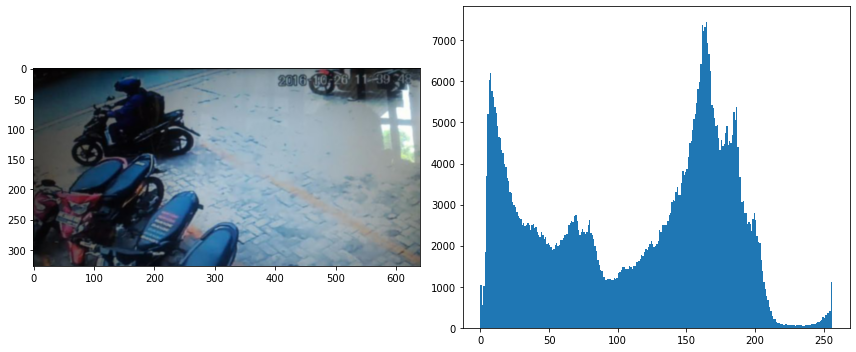

(327, 640, 3)
(163, 320, 3)


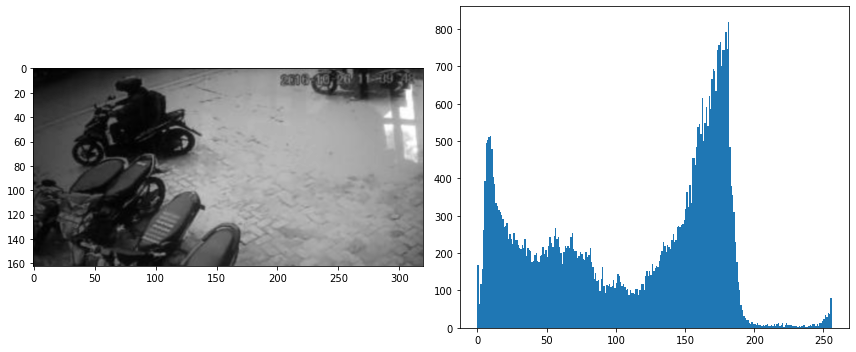

Histogram Equalization
> time-to-compute     : 0:00:01.033394
> peak-to-signal ratio: 19.903178543770636
Dynamic Histogram Equalization
> time-to-compute     : 0:00:07.609866
> peak-to-signal ratio: 15.914618066921198


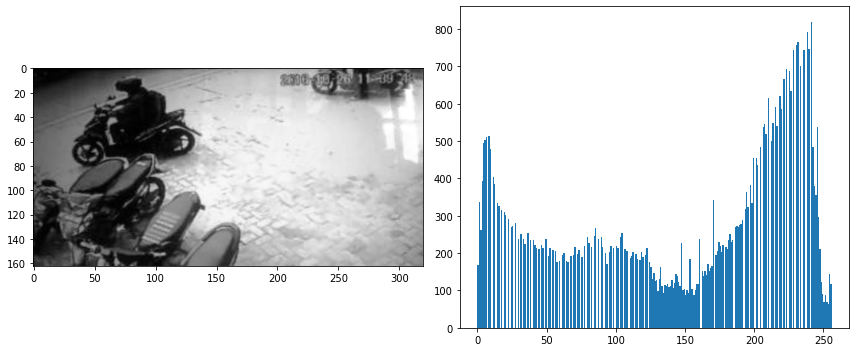

----------------------------------------------------



In [0]:
sources = [("dataset1.jpg", "https://cdn2.tstatic.net/lampung/foto/bank/images/cctv-pencurian-motor-di-ecayo-yamaha.jpg"), 
           ("dataset2.jpg", "http://www.jejamo.com/wp-content/uploads/2016/08/Curanmor.jpg"), 
           ("dataset3.jpg", "http://duajurai.co/wp-content/uploads/2016/10/Maling-Sepeda-Motor-di-La-Kita-Bakery-Anggri-27-Oktober.jpg")]
           
for i, src in enumerate(sources):
  name, link = src
  print(f"{i+1}. Image: {name}")
  if link: 
    !rm $name
    !wget $link -q -O $name

  tmp_img = Image.open(name)
  tmp_img = np.array(tmp_img)
  
  showImage(tmp_img)
  print(tmp_img.shape)

  # rescale
  width_scale = 0.5
  height_scale = 0.5
  new_width = int(tmp_img.shape[1] * width_scale)
  new_height = int(tmp_img.shape[0] * height_scale)
  new_img = np.zeros((new_height, new_width, 3))
  print(new_img.shape)
  for i in range(new_height):
    for j in range(new_width):
      new_img[i, j] = tmp_img[int(i/height_scale), int(j/width_scale)]

  new_img /= 255
  pltImg.imsave('data'+name, new_img)

  # grayscale
  tmp_img = tmp_img[: , :, 0]*0.33 + tmp_img[:, :, 1]*0.33 + tmp_img[:, :, 2]*0.33

  start = datetime.now()
  tmp_img = cv2.imread('data'+name, 0)
  showImage(tmp_img)

  img_equ = equalization(tmp_img)
  end = datetime.now() - start
  print("Histogram Equalization")
  print("> time-to-compute     :", end)
  print("> peak-to-signal ratio:", cv2.PSNR(tmp_img, img_equ))

  start = datetime.now()
  img_dqu = dynamic_equalization(tmp_img)
  end = datetime.now() - start
  print("Dynamic Histogram Equalization")
  print("> time-to-compute     :", end)
  print("> peak-to-signal ratio:", cv2.PSNR(tmp_img, img_dqu))
  showImage(img_dqu)


  print("----------------------------------------------------\n")

## Copyright &copy; 2019
***Image Enhancement using  Dynamic Histogram Equalization***\
Mia Sayida Fatma & Badrus shoolehk\
**PCD:** ICM-40-GAB02